# CLASSIFICATION OF R/SOURDOUGH POSTS PER FLAIR TAGS: 08 - STACKING CLASSIFIER

## 1) Introduction

### 1.1) General presentation: 

The aim of this project is to help predict the category of a post on the r/sourdough subreddit, based on its text content: its title, the content of the post itself and of the comments. More details on the general context of the project are provided in the first notebook : [01 - Exploratory Data Analysis](./01_exploratory_data_analysis.ipynb). 

The main strategy employed for the preprocessing of the data was a Bag-of-words approach, where the cleaning (cleaning, removing punctuation, numbers and  urls, lemmatization) and tokenization (splitting of the strings in smaller units; here words) was followed by counting each unique words to define the vocabulary. Then, each word was represented by its freqency in each post, pondered by its freqency in the whole corpus. The TF-IDF vectorizer was tuned to remove the noise(i.e.: words too frequent as well as words not frequent enough). 

In addition, posts categories were explored, and it was decided to regroup them in meta categories, as the large number of initial categories (40), paired with the large imbalance (some categories only having 1 observation, when others had  almost a thousand) would have lead to poor performance for the classifiers. 

Thus, the preprocessing resulted in two dataset: 
* A training set with 6713 observations and 1195 features that will be used to train our machine learning models through cross validation
* A test set with 2878 observations and 1195 features that will be used to test the performance of our models. 

The meta classes to predict, constructed based on insider knowledge of the r/sourdough subreddit are as follows: 
* Critique
* Discussion
* Help
* Look 

The Machine learning strategy for the project is as follows: 
1. Train multiple classifiers on the training set, using cross validation to tune the hyperparameters. These models, referred to as 0-level classifiers,  are: 
* Naive Bayes
* Logistic Regression
* K nearest neighbors
* Decision Tree
* Random Forest
* Support Vector Machine with a non linear kernel

2. Produce 5-folds out of bag predictions on the training set (divide the training set in 5 folds, fitting the optimal model on the first 4 folds to predict the fifth, repeat % times) from all 0-level classifiers and use these to perform a quick data exploration of the predictions. 

3. Stack the 0-level classifiers and train and fine tune the meta classifier. 

4. Evaluate all predictions(0-level and meta-classifier), by comparing their performance to a dummy classifier, using a stratified strategy (prediction randomly drawn from a distribution computed from the target variable distribution in the training set)

5. At the end of the process, we will discuss our results as well as the challenges we faced and the possible points of improvements that could be considered for the project. 

### 1.2) Aim of this notebook
This notebook aims at performing the training of a stacked classifier, using predictions from 0-levels classifier to build on them and improve their performance in categorizing reddit posts on the r/sourdough subreddit. 
Stacking is an ensembling method where we train several 0-level models on the same preprocessed dataset, then use their predictions as input in a meta model (1-level model). 

A good example ofensemble training is the Random Forest, where decision trees are used as 0-level models and their results averaged to provide the random forest predictions.
The assumption behind Stacking is that by using different imperfect 0-level models, that learn differently from the data, and aggregating their predictions into a higher level model, we can achieve a better performance. 
This is particularly true if the models highlight different features as the most important features in explaining the different class of the target variable, and if the prediction errors are not correlated between the 0-level models. 

### 2) Stacking strategy
During the course of this project, we have trained and tuned 6 different classifiers: 
* a Naive Bayes classifier
* a logistic classifier
* a K-nearest neighbors classifier
* a decision tree
* a random forest 
* a svm with a rbf kernel.

The general strategy to stack these models is as follows: 
1. Fine tune the 0-level classifiers
2. Chose the 0-level classifiers to include in the stack. 
3. Produce out of folds predictions on the training set (split the training set in 5 folds, fit the model on the first 4 folds, compute predictions on the last fold, repeat for all of the 5 folds). These OOF predictions will serve as a training set to train and tune the meta-classifier. Two strategies can be used for the predictions: either compute the predictions for the categories, or predict for each sample, its probability to belong to each class. We chose to use the probability predictions, as it provides more information than just the categories. 
4. Train the meta classifier on the 0-level predictions. 
5. Compute the 0-level predictions on the test set. 
6. Compute the final predictions, using the 0-level predictions on the test set as input data. 

The computation of the out of folds predictions, was performed in each of the relevant jupyter notebook. To choose the classifiers to include in the stack, we will first compare their predictions error to identify if they are uncorrelated. 

### 3) Loading 0-level outputs 

First, we load the data: 
* the 0-level models and their predictions
* the original preprocessed data
* the optimal set of parameters for the TF-IDF vectorizer, as established in [01 - Exploratory Data Analysis](./01_exploratory_data_analysis.ipynb). 

In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pickle

In [2]:
#try with  td-idf 
#load data
train_df = pd.read_csv('data/train/train_preprocessed_sourdough.csv', sep = '\t')
test_df = pd.read_csv('data/test/test_preprocessed_sourdough.csv', sep = '\t')


X_tr = train_df["standard_text"].values
X_te = test_df["standard_text"].values

from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y_tr = train_df["Flair_process"]
y_tr_enc = LE.fit_transform(y_tr)

y_te = test_df["Flair_process"]
y_te_enc = LE.transform(y_te)

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

#import best parameters for tf_idf
vec = open("./data/train/Tfidf_parameters.pickle", 'rb') # rb= read in bytes
tf_idf_search  = pickle.load(vec)
vec.close()
# Calculate TF-IDF
tf_idf = TfidfVectorizer(#max_features=tf_idf_search.best_params_['vect__max_features'],
                         min_df =tf_idf_search.best_params_['vect__min_df'], 
                         max_df = tf_idf_search.best_params_['vect__max_df'], 
                         use_idf = tf_idf_search.best_params_['vect__use_idf']
                        )

X_train_tfidf = tf_idf.fit_transform(X_tr)
X_test_tfidf = tf_idf.transform(X_te)

In [3]:
#loading all data 
# loading previous results

# load the model from disk
bayes_final, oof_bayes_proba_pred, oof_bayes_class_pred, oof_bayes_true = pickle.load(open('results/01_bayes.sav', 'rb'))
bayes_proba_pred =  pd.DataFrame(oof_bayes_proba_pred,columns = "bayes_"+LE.classes_, index =train_df["Post ID_x"])



# load the model from disk
logreg_final, oof_logreg_proba_pred, oof_logreg_class_pred,  oof_logreg_true  = pickle.load(open('results/02_logreg.sav', 'rb'))
lr_proba_pred = pd.DataFrame(oof_logreg_proba_pred ,columns = "lr_"+LE.classes_, index =train_df["Post ID_x"])
    
    
# load the model from disk
knn_final, oof_knn_proba_pred, oof_knn_class_pred, oof_knn_true = pickle.load(open('results/03_knn.sav', 'rb'))
knn_proba_pred = pd.DataFrame(oof_knn_proba_pred,columns = "knn_"+LE.classes_, index =train_df["Post ID_x"])



# load the model from disk
cart_final,oof_cart_proba_pred, oof_cart_class_pred, oof_cart_true = pickle.load(open('results/04_cart.sav', 'rb'))
cart_proba_pred = pd.DataFrame(oof_cart_proba_pred,columns = "cart_"+LE.classes_, index =train_df["Post ID_x"])



# load the model from disk
rf_final,oof_rf_proba_pred, oof_rf_class_pred, oof_rf_true = pickle.load(open('results/05_rf.sav', 'rb'))
rf_proba_pred = pd.DataFrame(oof_rf_proba_pred,columns = "rf_"+LE.classes_, index =train_df["Post ID_x"])
 


# load the model from disk
svc_final, oof_svc_proba_pred, oof_svc_class_pred, oof_svc_true = pickle.load(open('results/06_svc.sav', 'rb'))
svc_proba_pred = pd.DataFrame(oof_svc_proba_pred,columns = "svc_"+LE.classes_, index =train_df["Post ID_x"])





In [4]:
# making sure observations are in the same order in all predictions set:  
print(np.sum(oof_logreg_true == oof_bayes_true))
print(np.sum(oof_logreg_true == oof_knn_true))
print(np.sum(oof_logreg_true == oof_cart_true))
print(np.sum(oof_logreg_true == oof_rf_true))
print(np.sum(oof_logreg_true == oof_svc_true))

6713
6713
6713
6713
6713


 ### 4) Exploration of 0-level predictions
Now that all relevant datasets and models are loaded, we compute the classification error for each model.

For each model,  we assign 1 to observations where the class was incorrectly predicted, and 0 otherwise.


In [5]:
#merge all class proba
all_train_class_pred = pd.DataFrame({'bayes':  oof_bayes_class_pred, 
                        'logreg':  oof_logreg_class_pred,
                        'knn':  oof_knn_class_pred,
                        'cart':  oof_cart_class_pred,
                        'rf':  oof_rf_class_pred,
                        'svc':  oof_svc_class_pred
                       })

all_train_class_pred.head()

,bayes,logreg,knn,cart,rf,svc
0,2,2,2,2,2,2
1,2,2,2,2,2,2
2,3,3,3,0,3,3
3,2,2,2,0,2,2
4,1,1,1,2,1,1


In [6]:
all_error = pd.DataFrame({
    "bayes": [1 if x == y  else 0 for x,y in zip(oof_bayes_class_pred, oof_bayes_true)], 
    "logreg": [1 if x == y  else 0 for x,y in zip(oof_logreg_class_pred, oof_logreg_true)], 
    "knn": [1 if x == y  else 0 for x,y in zip(oof_knn_class_pred, oof_knn_true)], 
    "cart": [1 if x == y  else 0 for x,y in zip(oof_cart_class_pred, oof_cart_true)], 
    "rf": [1 if x == y  else 0 for x,y in zip(oof_rf_class_pred, oof_rf_true)], 
    "svc": [1 if x == y  else 0 for x,y in zip(oof_svc_class_pred, oof_svc_true)] 
})



The correlation matrix is displayed below. 

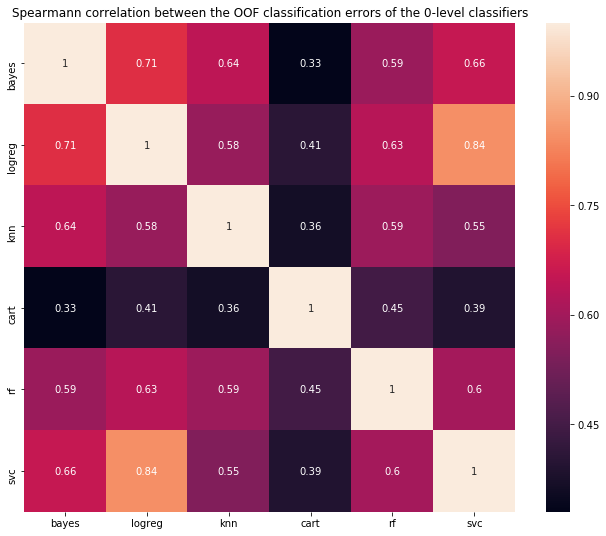

In [7]:
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(all_error.corr(method = "spearman"), annot = True)
plt.title("Spearmann correlation between the OOF classification errors of the 0-level classifiers")
plt.show()

At the exception of the SVC model and the logistic classifier, all correlations are pretty low, meaning that the classifiers, might be picking up information on different parts of the data. Thus, combining these classifiers in a stacking strategy might yield better results than taking all classifiers separately. 
The highest correlation is between SVC and logreg, and has a value of 0.84. 
As this correlation is high, we take the decision to only keep the logistic classifier and discard the SVC, has their infos would be redundant. Choosing the logistic classifier over the SVC was based on computational cost. 

In [8]:
#merge all predicted proba
all_train_proba_pred = bayes_proba_pred.merge(lr_proba_pred, left_index = True, right_index = True).merge(knn_proba_pred, left_index = True, right_index = True).merge(cart_proba_pred, left_index = True, right_index = True).merge(rf_proba_pred, left_index = True, right_index = True)


all_train_proba_pred.head().T

Post ID_x,mxv8wb,l1e53s,qo8d7r,k9ymng,lsrho0
bayes_Critique,0.011945,0.059808,0.142167,0.217914,0.152775
bayes_Discussion,0.060656,0.024937,0.066673,0.323738,0.549603
bayes_Help,0.899834,0.890938,0.057413,0.429272,0.226808
bayes_Look,0.027564,0.024317,0.733747,0.029076,0.070814
lr_Critique,0.066198,0.290168,0.299465,0.163207,0.112144
lr_Discussion,0.089556,0.011555,0.046497,0.285632,0.559671
lr_Help,0.758608,0.636474,0.029997,0.503307,0.222495
lr_Look,0.085638,0.061803,0.624041,0.047854,0.105690
knn_Critique,0.066667,0.044444,0.144444,0.133333,0.100000
knn_Discussion,0.088889,0.077778,0.100000,0.166667,0.377778


Before fitting the meta model, we perform a PCA on the probability predictions. 

In [9]:
#checking predictions with pca
from sklearn.decomposition import PCA

y = oof_bayes_true

# Dimension reduction 
pca=PCA(n_components = None)

#No need for scaling, all values already between 0 and 1
X_pca = pca.fit(all_train_proba_pred)

# Proportion of variance explained
pve = X_pca.explained_variance_ratio_
pve[:10]


array([0.52699638, 0.18472628, 0.08718497, 0.06238191, 0.0468959 ,
       0.04014029, 0.01438585, 0.01010942, 0.00651879, 0.00565772])

First, we plot the proportion of variance explained by each components.

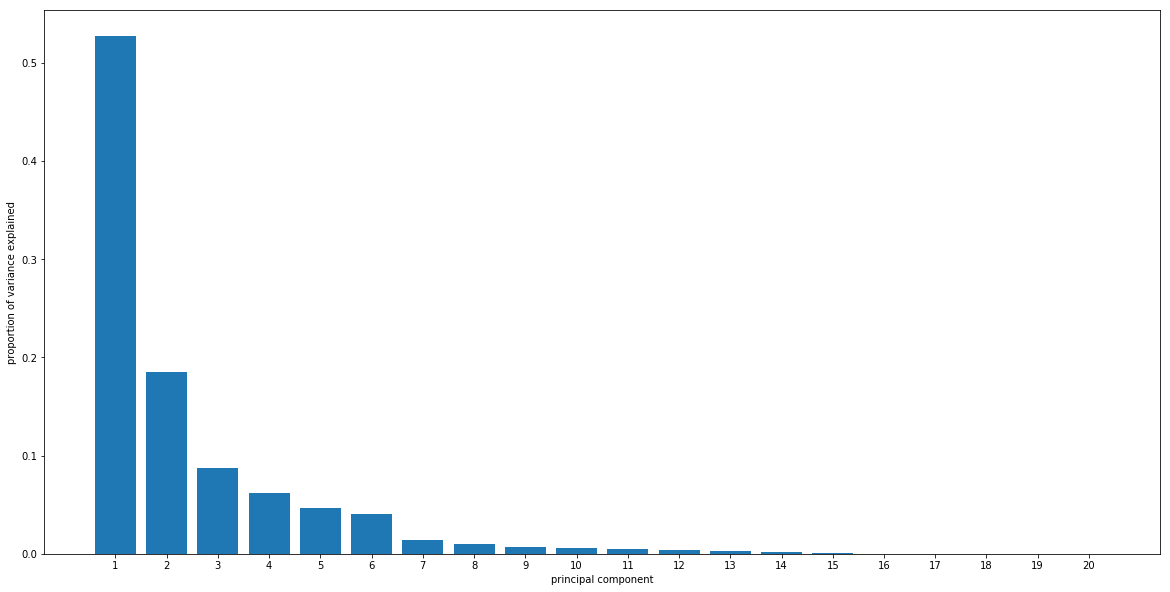

In [10]:
# Create bar plot
fig = plt.figure(figsize = (20,10))
xcor = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)



# Add labels
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')

plt.show()

The first component explaines around 55% of the variance in the probability predictions, while the second explains around 20%. The first two components explain at least 70% of the variance. 3 components explain at least 80% of the variance and 5 components are necessary to explain at least 90% of the variance. 

We thus perform a PCA with the first three components and project the observations on them: 

In [11]:
for kind in np.sort(pd.unique(LE.inverse_transform(y))):
    print(kind)

Critique
Discussion
Help
Look


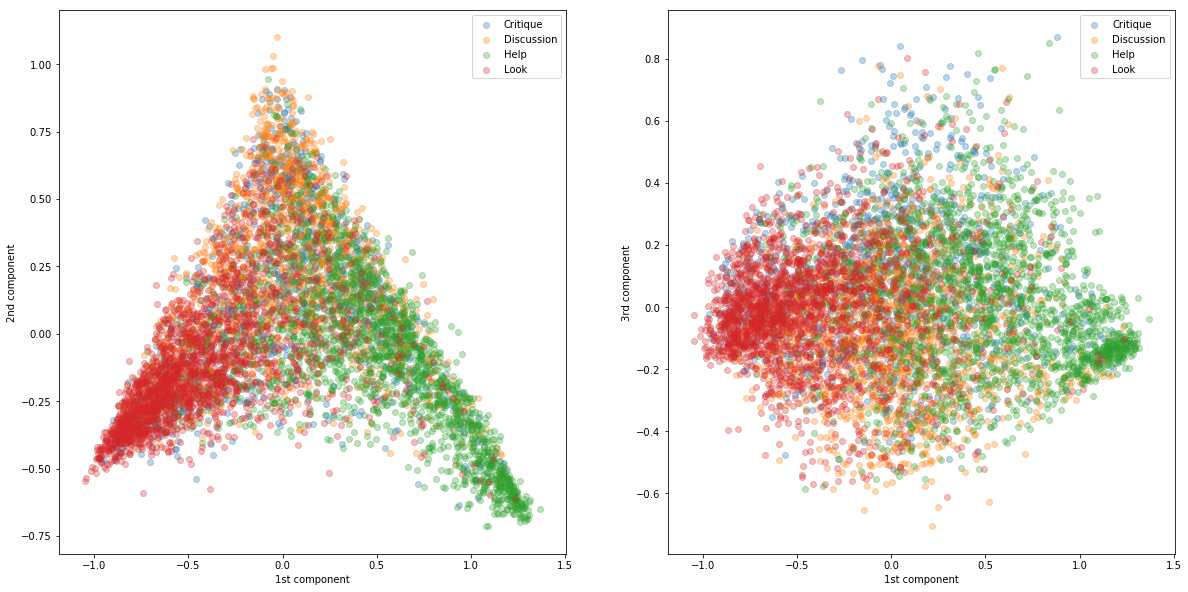

In [12]:
#project data on the first two components
pca_2=PCA(3)
pca_2d = pca_2.fit_transform(all_train_proba_pred)
fig, (axs) = plt.subplots(nrows = 1, ncols=2, sharex = True, sharey = False,  figsize=(20,10))
for kind in np.sort(pd.unique(LE.inverse_transform(y))):
    # Wine samples of this type
    idx = (LE.inverse_transform(y) == kind)

    # Plot their components
    axs[0].scatter(
        pca_2d[idx, 0], pca_2d[idx, 1],
        label='{}'.format(kind), alpha = 0.3
    )
    
for kind in np.sort(pd.unique(LE.inverse_transform(y))):
    # Wine samples of this type
    idx = (LE.inverse_transform(y) == kind)

    # Plot their components
    axs[1].scatter(
        pca_2d[idx, 0], pca_2d[idx, 2],
        label='{}'.format(kind), alpha = 0.3
    )

# Labels and legend
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('1st component')
axs[1].set_xlabel('1st component')
axs[0].set_ylabel('2nd component')
axs[1].set_ylabel('3rd component')
plt.show()

We can see that the predictions tend to manage to group the posts per Flair on the 2 first components. 
For more clarity, the plots below projects the posts, Flair per flair on the 3 thirst components. 

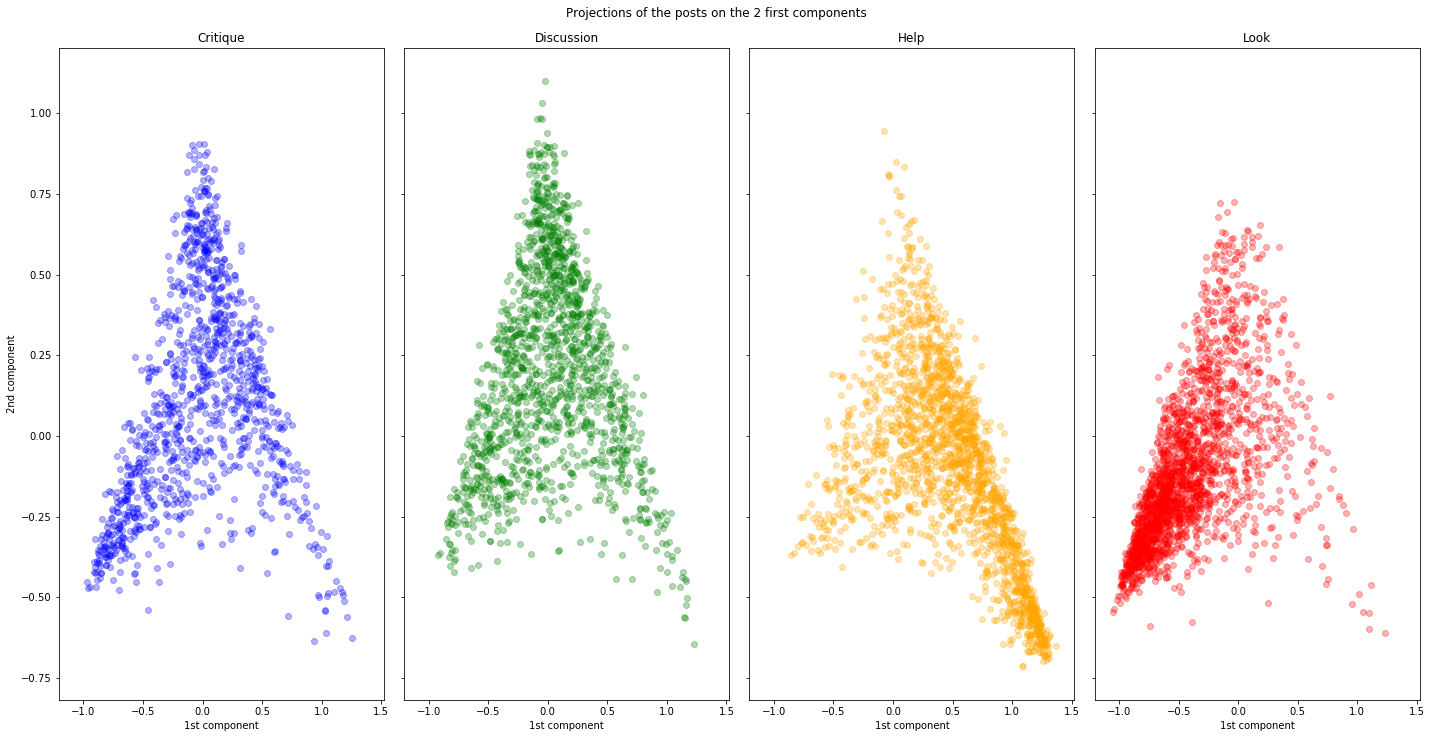

In [13]:
# Plotting distribution of number of words in Title, OP Text and Comments per posts 
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows = 1, ncols=4, sharex = True, sharey = True,  figsize=(20,10))
fig.subplots_adjust(top=0.8)
idx1 = (LE.inverse_transform(y) == "Critique")
idx2 = (LE.inverse_transform(y) == "Discussion")
idx3 = (LE.inverse_transform(y) == "Help")
idx4 = (LE.inverse_transform(y) == "Look")


ax1.scatter(
    pca_2d[idx1, 0], pca_2d[idx1, 1],
    label='{}'.format("Critique"), alpha = 0.3, color = "blue"
)



ax2.scatter(
    pca_2d[idx2, 0], pca_2d[idx2, 1],
    label='{}'.format("Discussion"), alpha = 0.3, color = "green"
)

ax3.scatter(
    pca_2d[idx3, 0], pca_2d[idx3, 1],
    label='{}'.format("Help"), alpha = 0.3, color = "orange"
)

ax4.scatter(
    pca_2d[idx4, 0], pca_2d[idx4, 1],
    label='{}'.format("Look"), alpha = 0.3, color = "red"
)
ax1.set_title("Critique")
ax2.set_title("Discussion")
ax3.set_title("Help")
ax4.set_title("Look")
ax1.set_xlabel('1st component')
ax2.set_xlabel('1st component')
ax3.set_xlabel('1st component')
ax4.set_xlabel('1st component')
ax1.set_ylabel('2nd component')

plt.suptitle("Projections of the posts on the 2 first components", y=1.02)

plt.tight_layout()
plt.show()

The first components tend to be characterized by an opposition between Help posts (positively correlated with 1st component) and Look posts (negatively correlated with 1st component). The second component tends to be characterized by an opposition between Discussion and Critique posts (positively correlated with 2nd component) and Look and Discussion (negatively correlated with the second component). 

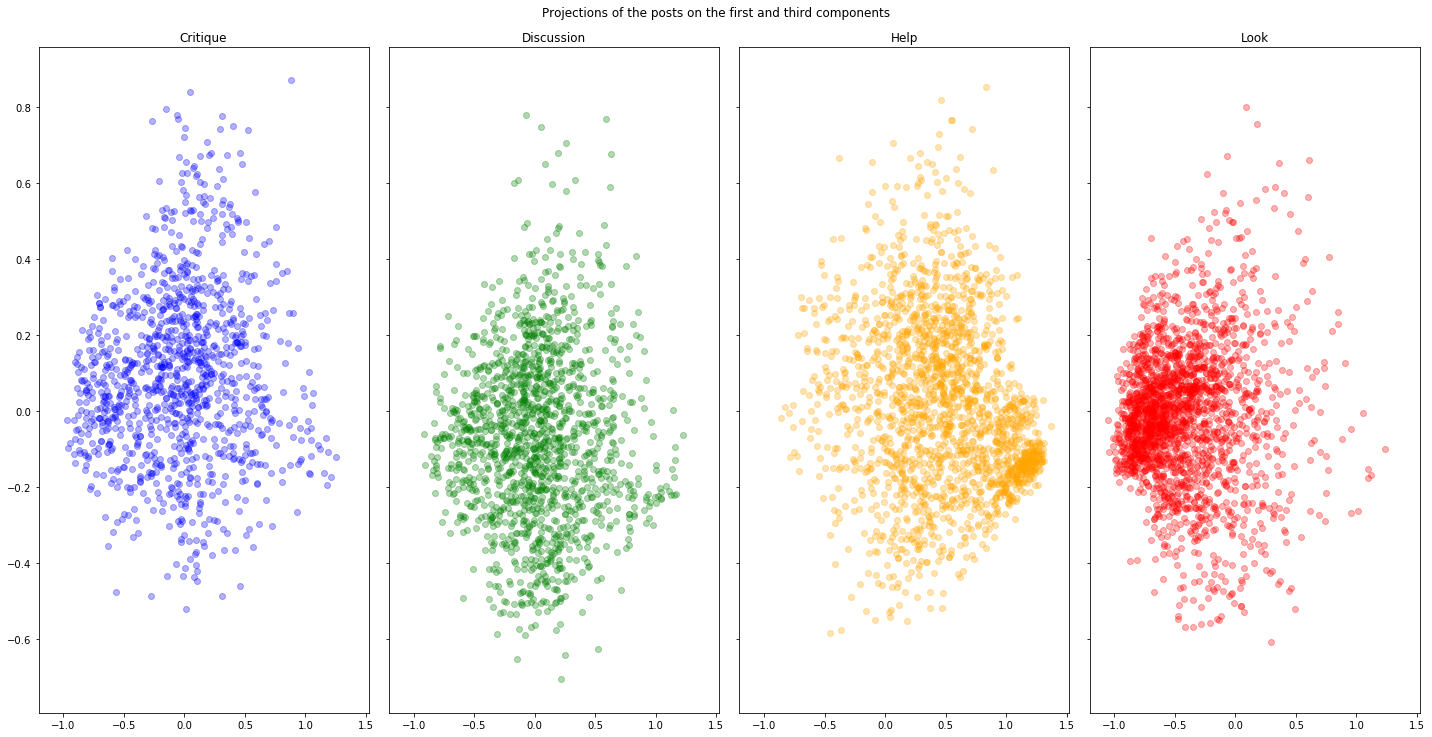

In [14]:
# Plotting distribution of number of words in Title, OP Text and Comments per posts 
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(nrows = 1, ncols=4, sharex = True, sharey = True,  figsize=(20,10))
fig.subplots_adjust(top=0.8)
idx1 = (LE.inverse_transform(y) == "Critique")
idx2 = (LE.inverse_transform(y) == "Discussion")
idx3 = (LE.inverse_transform(y) == "Help")
idx4 = (LE.inverse_transform(y) == "Look")


ax1.scatter(
    pca_2d[idx1, 0], pca_2d[idx1, 2],
    label='{}'.format("Critique"), alpha = 0.3, color = "blue"
)



ax2.scatter(
    pca_2d[idx2, 0], pca_2d[idx2, 2],
    label='{}'.format("Discussion"), alpha = 0.3, color = "green"
)

ax3.scatter(
    pca_2d[idx3, 0], pca_2d[idx3, 2],
    label='{}'.format("Help"), alpha = 0.3, color = "orange"
)

ax4.scatter(
    pca_2d[idx4, 0], pca_2d[idx4, 2],
    label='{}'.format("Look"), alpha = 0.3, color = "red"
)
ax1.set_title("Critique")
ax2.set_title("Discussion")
ax3.set_title("Help")
ax4.set_title("Look")


plt.suptitle("Projections of the posts on the first and third components", y=1.02)

plt.tight_layout()
plt.show()

The third component seems to be driven by an opposition between Critique posts (positively correlated with the third component), and Discussion posts (negatively correlated with the third component).   

### 5) Training the meta classifier

For the metaclassifier, we chose to use the logistic regression. Among all our 0-level models, the logistic regression was one of the more accurate, while being computationally efficient at the same time. 
Using a logistic regression, is thus equivalent as computing the final predictions as a linear combination of the 0-level probability predictions. 

To train the metaclassifier, we will use the StackingClassifier function from sklearn on the TF-IDF vectorized data, feeding as 0-level models our fine-tuned models and specifying the logistic regression as the final estimator. Using the sklearn API, will ensure that no data leakage happens between the estimation of the 0-level predictions and the training of the meta-classifier.

Before fitting the metaclassifier, we perform a grid search on its hyper parameters, using cross-validation to identify the best set of parameters. 

#### Hyper-paramaters tuning  
The three parameters that we will tune for the meta logistic classifier are: 
* C: used to tune the regularization; the smaller, the greater the regularization
* class: the type of classification performed: One vs all or multinomial 
* solver: solver to be used according to the type of classification performed. 


#### Classes imbalance
As for the 0-level classifiers, this will be delt by setting the class_weight parameter to 'balanced', in order to adjust weights inversely proportional to class frequencies in the input data during training.  

#### Grid search
Next, we define and run the grid search: 

In [15]:
# load the weak learners: 

# compare ensemble to each baseline classifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

In [16]:
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

In [17]:
classifiers = [('bayes',bayes_final.named_steps["bayes"]),
               ('logreg', logreg_final.named_steps["logreg"]), 
               ('knn', knn_final.named_steps["knn"]),
               ('cart', cart_final.named_steps["cart"]), 
               ('rf', rf_final.named_steps["rf"])
              ]

In [18]:
meta = StackingClassifier(estimators=classifiers, 
                         final_estimator=LogisticRegression(random_state = 42, max_iter = 1000000000, class_weight  = 'balanced'),
                         stack_method='predict_proba',
                         n_jobs=-1,
                         passthrough=False)

In [19]:
clf = Pipeline([
    ('meta', meta)
])
Cs = np.logspace(-4, 4, num=20)

grids = [{
    'meta__final_estimator__multi_class': ['ovr'],
    'meta__final_estimator__solver': ['liblinear'],
    'meta__final_estimator__C': Cs
}, {
    'meta__final_estimator__multi_class': ['multinomial'],
    'meta__final_estimator__solver': ['saga'],
    'meta__final_estimator__C': Cs
}]

meta_gridCV = GridSearchCV(clf, 
                           grids, 
                           cv=skf,
                           scoring = "f1_weighted",
                           refit=True, 
                           return_train_score=True, 
                           verbose = 1, n_jobs = -1)

In [20]:
%%time
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Fit/evaluate estimator
meta_gridCV.fit(X_train_tfidf, y_tr_enc)

# Collect results in a DataFrame
meta_results = pd.DataFrame({
    'solver': meta_gridCV.cv_results_['param_meta__final_estimator__solver'],
    'strategy': meta_gridCV.cv_results_['param_meta__final_estimator__multi_class'],
    'C': meta_gridCV.cv_results_['param_meta__final_estimator__C'],
    'mean_tr': meta_gridCV.cv_results_['mean_train_score'],
    'mean_val': meta_gridCV.cv_results_['mean_test_score'],
    'std_val': meta_gridCV.cv_results_['std_test_score']
})

# Ten best combinations according to the mean test score
meta_results.sort_values(by='mean_val', ascending=False).head(10)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Wall time: 4min 36s


,solver,strategy,C,mean_tr,mean_val,std_val
9,liblinear,ovr,0.615848,0.670956,0.584645,0.010061
10,liblinear,ovr,1.62378,0.676930,0.584591,0.010624
11,liblinear,ovr,4.28133,0.682066,0.583815,0.010318
12,liblinear,ovr,11.2884,0.685089,0.583630,0.009964
15,liblinear,ovr,206.914,0.687907,0.583500,0.010428
14,liblinear,ovr,78.476,0.687550,0.583355,0.010655
16,liblinear,ovr,545.559,0.688021,0.583331,0.010184
17,liblinear,ovr,1438.45,0.688014,0.583198,0.010206
19,liblinear,ovr,10000,0.688014,0.583028,0.009965
18,liblinear,ovr,3792.69,0.687979,0.583028,0.009965


The best averaged f1-score during cross validation is 58%, with a liblinear solver, a one-vs-all strategy and a regularization parameter C of 0.616.

### 6) Predictions on the test set

#### Classification performance

We now fit the meta classifier a last time on the whole whole training set and use the trained model to predict the test set. 

In [21]:
best_metalog_params = meta_results.iloc[meta_results['mean_val'].idxmax(), :]

In [22]:
# Logistic regression estimator on whole training + validation sets
meta_final = Pipeline([
    ('meta', StackingClassifier(estimators=classifiers, 
                         final_estimator=LogisticRegression(
                             C = best_metalog_params['C'], 
                                  multi_class  = best_metalog_params['strategy'], 
                                  solver = best_metalog_params['solver'], 
                                  class_weight  = 'balanced', 
                                  random_state = 42)))
])

meta_final.fit(X_train_tfidf, y_tr_enc)

Pipeline(steps=[('meta',
                 StackingClassifier(estimators=[('bayes',
                                                 MultinomialNB(alpha=1e-10)),
                                                ('logreg',
                                                 LogisticRegression(C=0.615848211066026,
                                                                    class_weight='balanced',
                                                                    multi_class='ovr',
                                                                    random_state=0,
                                                                    solver='liblinear')),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=90)),
                                                ('cart',
                                                 DecisionTreeClassifier(class_weight='balanced',
                                       

In [23]:
# Report test score
meta_accuracy = meta_final.score(X_test_tfidf, y_te_enc)
print('Test accuracy of the final meta classifier: {:.2f}%'.format(100*meta_accuracy))

from sklearn.metrics import f1_score
print('Test weighted F1 score of the final metaclassifier: {:.2f}'.format(100*f1_score(y_te_enc, meta_final.predict(X_test_tfidf), average = 'weighted')))

Test accuracy of the final meta classifier: 59.28%
Test weighted F1 score of the final metaclassifier: 58.57


In addition to the f1 score, we produce the classification report below:

In [24]:
 print(classification_report(y_te_enc, meta_final.predict(X_test_tfidf), target_names = LE.classes_))

              precision    recall  f1-score   support

    Critique       0.44      0.34      0.38       488
  Discussion       0.50      0.47      0.49       652
        Help       0.66      0.67      0.66       827
        Look       0.65      0.74      0.69       911

    accuracy                           0.59      2878
   macro avg       0.56      0.56      0.56      2878
weighted avg       0.58      0.59      0.59      2878



In addition to the f1-score, the report displays the precision, the recall as well as the accuracy. 
* The precision is the ratio of correctly predicted observations in a class to the total predicted observations in this classe. In other words, for a given Flair, how many of the observations predicted in this class actually belong to it. 
* The recall is the ratio of correctly predicted observations in a class to the total number of observations in this actual class. In other words, for a given Flair, how many of the observtaions belonging to it were correctly identified. 

As for the 0-level classifiers, Critique and Discussion are the flairs with the worst precision and recall. Only 44% of the posts that are predicted as Critique actually belong to this class, and only 34% of the posts in this flair are correctly predicted. Only 50% of the posts predicted as Discussion actually belong to this class, and 47% of the of the posts in this flair are being correctly predicted. 

The Help category has the best precision, with 66% of the posts predicted as Help, actually belonging to this Flair. The recall is the same, with also 67% of the posts in this flair being correctly predicted. 
Finally, Look is the flair with the best recall, with 74% of the posts belonging to this flair being correctly predicted and 65% of the posts predicted as Look, actually belonging to this Flair. 

The confusion matrix below shows this by displaying the repartition of the predictions in each classe: 

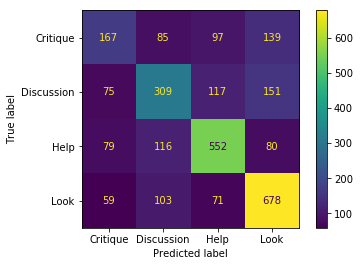

In [25]:
disp = ConfusionMatrixDisplay(
        confusion_matrix(y_te_enc,  meta_final.predict(X_test_tfidf)),
        display_labels=LE.classes_,
        #cmap=plt.cm.Blues,
        #normalize=True,
    ).plot()
#disp.ax_.set_title("Confusion matrix")

#print(title)
#print(disp.confusion_matrix)

plt.show()


The results are very similar to what had already been observed with the 0-level models. 

Critique posts tend to be mainly predicted either as Critique or Help. 

Around 50% of the Discussion posts tend to be correctly predicted. The incorrect predictions are split between Help and Look. 

Help and Look posts tend to be very well predicted.  

Finally, we are interested in investigating which predictions were the most important for the classification task. 

#### Top predictions to discriminate between Flairs

There is no Feature_importances attribute for the stackingclassifier() method in sklearn. One way to investigate feature importance is thus to use the Permutation feature importance test. 
During the process, values in a single feature at a time are randomly shuffled and a prediction score is computed on this new data. The shuffle is performed K times per feature, then the importance is computed as the difference between the original score and the average of the scores on the shuffled data. The higher this difference is, the more the feature being shuffled is important. 

As the meta classifier use the predicted probabilities of the 0-level models to compute its prediction, the final predictions are actually computed using a matrix with only 20 features (4 class probabilities for each of the 5 0-level model), rendering this test easier to perform than on the 0-level classifiers themselves which have more than 1000 features each. 

We first: 
* use the fit_transform() and transform() methods to compute the matrices of 0-level predictions on the train and test set
* fit the optimal logistic regression on the training probabilities 
* predict on the test set using the test probabilities 
* use the permutation_importance() function with the f1 score as the scorer, to identify the most important features. 

In [26]:
from sklearn.inspection import permutation_importance

In [27]:
# prepare dataset to test feature importance
test_x_tr = meta_final.fit_transform(X_train_tfidf, y_tr_enc)
test_x_te = meta_final.transform(X_test_tfidf)
meta_feature_names = list(all_train_proba_pred.columns.values)

log_stack = LogisticRegression(C=78.47599703514607,
                               multi_class='ovr',
                               random_state=42,
                               class_weight  = 'balanced',
                               solver='liblinear')

log_stack.fit(test_x_tr, y_tr_enc)

imps = permutation_importance(log_stack, test_x_te, y_te_enc, n_repeats=10, random_state=0, n_jobs=-1, scoring = "f1_weighted")
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

Importance features are displayed on the barplot below: 

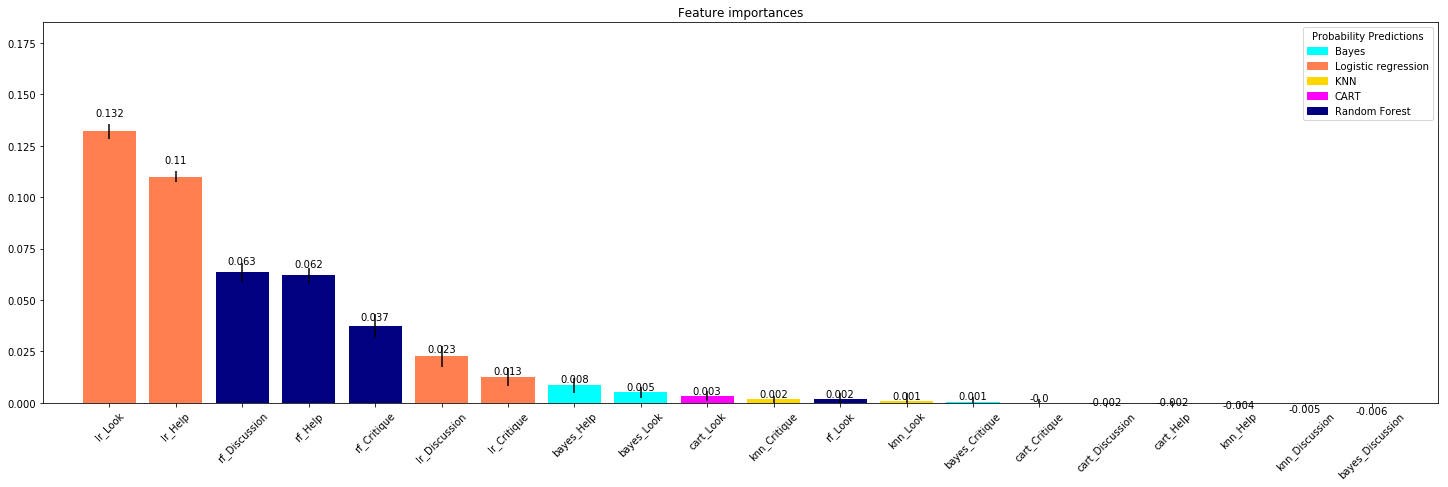

In [28]:
import matplotlib.patches as mpatches

bayes_patch = mpatches.Patch(color='aqua', label='Bayes')
logreg_patch = mpatches.Patch(color='coral', label='Logistic regression')
knn_patch = mpatches.Patch(color='gold', label='KNN')
cart_patch = mpatches.Patch(color='magenta', label='CART')
rf_patch = mpatches.Patch(color='navy', label='Random Forest')

bar_label = np.round(importances[indices] , 3)
cols = np.repeat(['aqua', 'coral', 'gold', 'magenta', 'navy'], 4)

fig, ax = plt.subplots(figsize=(25, 7))
bar_plot = plt.bar(range(len(meta_feature_names)), importances[indices], color=cols[indices], yerr=std[indices], align="center")
plt.xticks(range(len(meta_feature_names)), [meta_feature_names[indices[i]] for i in range(len(meta_feature_names))], rotation = 45)
plt.xlim([-1, len(meta_feature_names)])
plt.ylim([0, 0.185])
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)
plt.legend(title = 'Probability Predictions', handles=[bayes_patch, logreg_patch, knn_patch, cart_patch, rf_patch])

plt.title("Feature importances")
plt.show()

The most important features for the stacking classifier generally come from the logistic regression and random forest predicted probabilities. The most important feature is the Look probability computed by the logistic regression, followed by the Help probability computed by the logistic regression, the Help probability, Discussion probability and Critique probability computed by the random forest. 

Finally, we save this final stacking model for the final comparison of all models. 

In [29]:
# save the model to disk
import pickle
filename = 'results/07_stack.sav'
pickle.dump(meta_final,  open(filename, 'wb'))